# Week 6: CFGs and PDAs are equivalent

In [1]:
from tock import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches, matplotlib.lines as lines

## Monday reading

Read Section 2.2, Lemma 2.21.

## Tuesday class

This week we'll show that the two models we learned last week, context-free grammars and pushdown automata, are equivalent. Today we will show how to convert a context-free grammar to a pushdown automaton, which is important because it is the basis for a lot of _parsing_ algorithms (algorithms that take a string as input, decide whether it belongs to the language, and if so, generates a tree as output).

### The top-down construction

The construction used in the proof of Lemma 2.21 is known as _top-down_ or sometimes "nondeterministic LL" parsing.

The basic idea is pretty simple, and probably easier to describe first without getting into the details of the PDA. The stack is initialized to $S\mathtt{$}$ (remember that the top of the stack is on the left). 

Whenever the top stack symbol is a terminal symbol and it matches the next input symbol, we pop it and read in the input symbol. If it doesn't match, then this path of the derivation rejects.

Whenever the top stack symbol is a nonterminal symbol, we pop it and nondeterministically push _all possible_ replacements for the nonterminal. Each replacement is pushed in reverse order, so that the leftmost symbol is on the top.

If we reach the end of the input string and the stack just has $\mathtt{$}$, then we accept.

Here's an example grammar:

\begin{align*}
S &\rightarrow \mathtt{a} T \mathtt{b} \\
S &\rightarrow \mathtt{b} \\
T &\rightarrow T \mathtt{a} \\
T &\rightarrow \varepsilon
\end{align*}

Here's what the _successful_ parse looks like for string `aaab`:

| Input | Stack |
|-------|-------|
|`aaab` | _S_`$`|
|`aaab` | `a`_T_`b$` |
|`aab` | _T_`b$` |
|`aab` | _T_`ab$` |
|`aab` | _T_`aab$` |
|`aab` | `aab$` |
|`ab` | `ab$` |
|`b` | `b$` |
|$\varepsilon$ | `$` |

There are also many unsuccessful parses, but as long as one of them succeeds, we accept the string.

The conversion from CFG to PDA basically implements the above algorithm in the PDA. This construction is implemented in Tock:

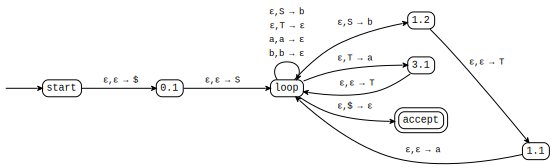

In [2]:
g = Grammar.from_lines(["S -> a T b",
                        "S -> b",
                        "T -> T a",
                        "T -> &"])
p1 = from_grammar(g)
to_graph(p1)

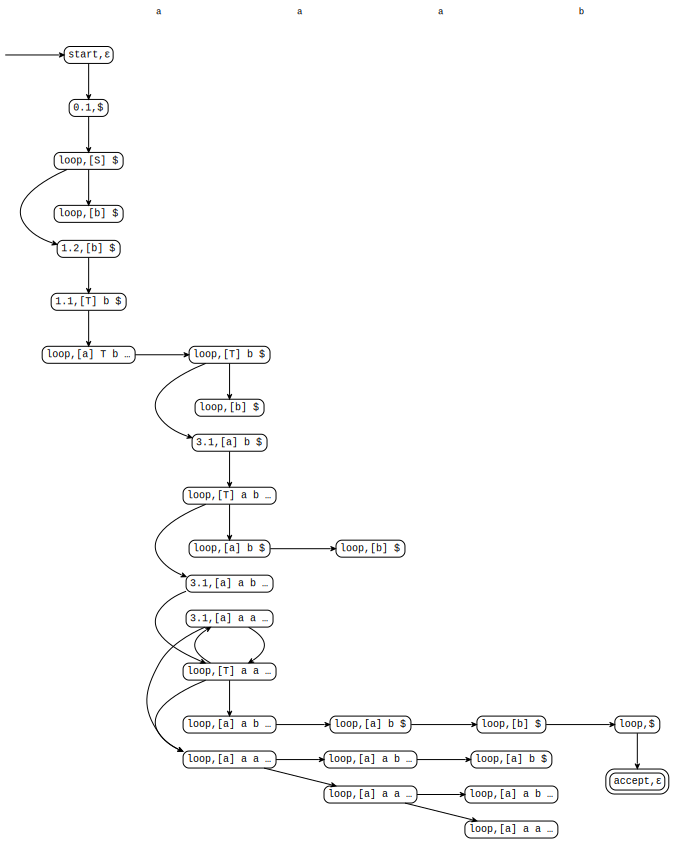

In [3]:
run(p1, "a a a b")

**Question.** Convert the following CFG to a PDA:

\begin{align*}
S &\rightarrow \mathtt{0} S \mathtt{0} \\
S &\rightarrow \mathtt{1} S \mathtt{1} \\
S &\rightarrow \varepsilon
\end{align*}

**Question.** If you actually had to implement a parser this way, how would you do it? What would its time complexity be?

### The bottom-up construction (optional)

There's another parsing strategy that the book doesn't mention at this point. It's called _bottom-up_, _shift-reduce_, or maybe sometimes "nondeterministic LR" parsing. It's the basis for most parsing algorithms that are used in compilers.

The idea is again pretty simple -- it's like top-down parsing in reverse. The stack is initialized to $\mathtt{\$}$. At any point in time, we can do two operations.

In a _shift_, we read in one input symbol and push it onto the stack.

In a _reduce_, we check to see if the prefix (top symbols) of the stack match a right-hand-side of a rule (in reverse order), and if so, we can pop those symbols and replace them with the left-hand-side of the rule.

This algorithm is again nondeterministic: it's always possible to do a shift unless we're at the end of the string, and it may be possible to do several different reduces.

If we reach the end of the input and the stack has just $S\mathtt{\$}$, then we accept.

Here's what the _successful_ parse looks like for string `aaab`:

| Input | Stack |
|-------|-------|
|`aaab` | `$`|
|`aab` | `a$` |
|`aab` | _T_`a$` |
|`ab` | `a`_T_`a$` |
|`ab` | _T_`a$` |
|`b` | `a`_T_`a$` |
|`b` | _T_`a$` |
|$\varepsilon$ | `b`_T_`a$` |
|$\varepsilon$ | _S_`$` |


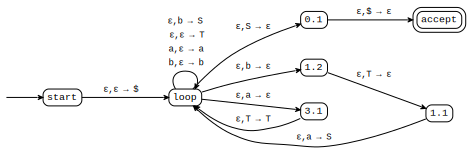

In [4]:
p2 = from_grammar(g, mode="bottomup")
to_graph(p2)

## Wednesday reading

Read Section 2.2, Lemma 2.27.

## Thursday class

The conversion from a PDA to a CFG is probably the trickiest to understand of all the constructions we do in this class. Fortunately, though, it's not very difficult to perform.

Let's start with an example PDA, one that recognizes the language of balanced parentheses but using `a` and `b` for left and right parentheses:

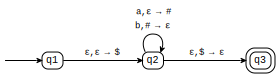

In [5]:
mc = read_csv("pda-parens.csv")
to_graph(mc)

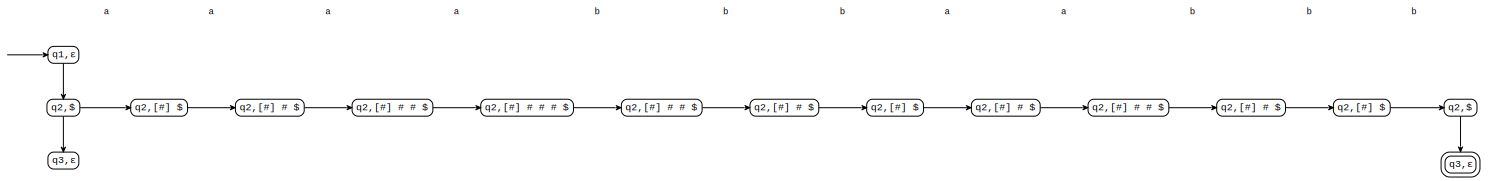

In [6]:
w = list("aaaabbbaabbb")
r = run(mc, w, show_stack=100)
r

The book uses plots of stack height over time (Figure 2.28 and 2.29) to help illustrate the construction. Here's a function that produces similar plots (you don't need to understand this):

In [7]:
def plot_height(ax, path):
    n = len(path)
    heights = [len(c[2]) for c in path]
    bars = ax.bar(np.arange(n), heights)
    ax.set_xticks(np.arange(n-1)+0.5)
    labels = []
    for i in range(n-1):
        if len(path[i][1]) > len(path[i+1][1]):
            labels.append(path[i][1][0])
        else:
            labels.append("")
    ax.set_xticklabels(labels)
    ax.set_xlabel("input string")
    ax.set_yticks(np.arange(max(heights)+1))
    ax.set_ylim(ymax=max(heights)+0.5)
    ax.set_ylabel("stack height")
    
    for c, b in zip(path, bars):
        h = b.get_height()
        ax.text(b.get_x() + b.get_width()/2., h, c[0], ha="center", va="bottom")


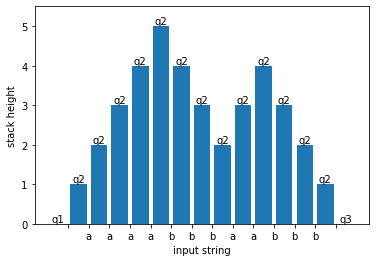

In [8]:
fig, ax = plt.subplots()
plot_height(ax, r.shortest_path())
plt.show()

Each bar (including bars with zero height) represents a configuration of the machine as it reads the string. The machine's state is written above the bar. The horizontal axis shows the input symbols that are read in (if any) and the vertical axis is the height of the stack. In this case, notice how the stack grows whenever an `a` is read and shrinks whenever a `b` is read.

You can try changing the input string `w` or even the PDA to see how the above graph changes. (However, the figures below will get messed up.)

A sequence of configurations like this is called a _run_. Let's define a _sub-run_ to be a contiguous subsequence of a run that begins and ends with the same stack $t$ and does not pop any symbols in $t$ (not even if it pushes the same symbols back).

For example, the blue rectangle below highlights a sub-run:

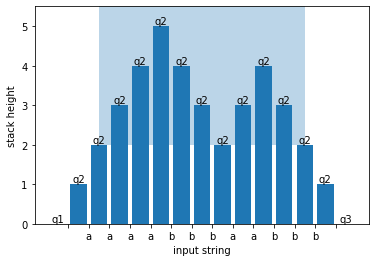

In [11]:
fig, ax = plt.subplots()
plot_height(ax, r.shortest_path())
ax.add_patch(patches.Rectangle((2,2),10,3.5,alpha=0.3))
plt.show()

But this isn't a sub-run, because it doesn't start and end with the same stack:

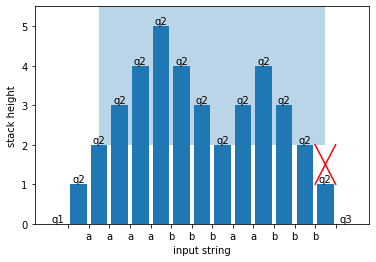

In [16]:
fig, ax = plt.subplots()
plot_height(ax, r.shortest_path())
ax.add_patch(patches.Rectangle((2,2),11,3.5,alpha=0.3))
ax.add_line(lines.Line2D([12.5,13.5],[1,2], color="red"))
ax.add_line(lines.Line2D([12.5,13.5],[2,1], color="red"))
plt.show()

And this isn't a sub-run, because it pops a symbol from the starting/ending stack:

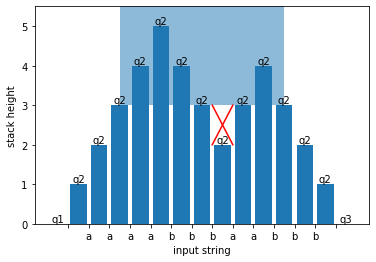

In [18]:
fig, ax = plt.subplots()
plot_height(ax, r.shortest_path())
ax.add_patch(patches.Rectangle((3,3),8,2.5,alpha=0.5))
ax.add_line(lines.Line2D([7.5,8.5],[2,3], color="red"))
ax.add_line(lines.Line2D([7.5,8.5],[3,2], color="red"))
plt.show()

The idea behind the conversion to CFG is that **sub-runs become sub-trees**. A sub-run that starts in state $q$ and ends in state $r$ is going to become a sub-tree that is rooted in the nonterminal $A_{qr}$.

The whole run is a sub-run. It is generated by the nonterminal symbol $A_{q_1q_3}$, which we make the start symbol. We can picture it as below:

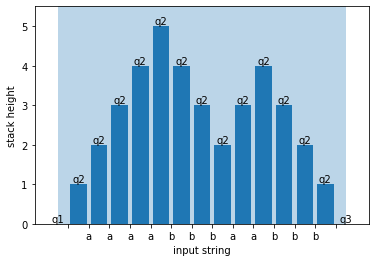

In [19]:
fig, ax = plt.subplots()
plot_height(ax, r.shortest_path())
ax.add_patch(patches.Rectangle((0,0),14,5.5,alpha=0.3))
plt.show()

Because the run starts and ends with epsilon transitions, there's also a sub-run that covers the whole string but begins in state $q_2$ and ends in state $q_2$:

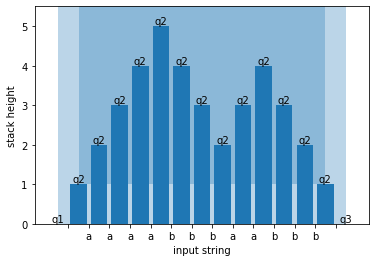

In [20]:
fig, ax = plt.subplots()
plot_height(ax, r.shortest_path())
ax.add_patch(patches.Rectangle((0,0),14,5.5,alpha=0.3))
ax.add_patch(patches.Rectangle((1,1),12,4.5,alpha=0.3))
plt.show()

So we should add a rule $A_{q_1q_3} \rightarrow A_{q_2q_2}$. The next smallest sub-run is the one that covers the whole string except the first and last symbols. It, too, begins in state $q_2$ and ends in state $q_2$:

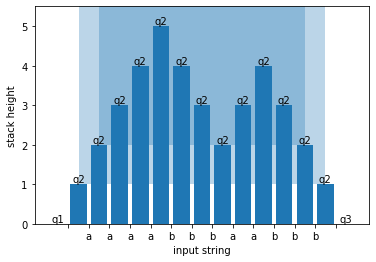

In [21]:
fig, ax = plt.subplots()
plot_height(ax, r.shortest_path())
ax.add_patch(patches.Rectangle((1,1),12,4.5,alpha=0.3))
ax.add_patch(patches.Rectangle((2,2),10,3.5,alpha=0.3))
plt.show()

So we should add a rule $A_{q_2q_2} \rightarrow \texttt{a} A_{q_2q_2} \texttt{b}$. Now what is the next smallest sub-run? Notice that if we lop off the first and last symbols again, the result wouldn't be a sub-run:

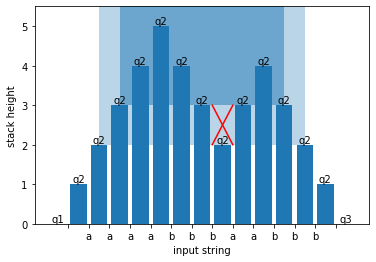

In [17]:
fig, ax = plt.subplots()
plot_height(ax, r.shortest_path())
ax.add_patch(patches.Rectangle((2,2),10,3.5,alpha=0.3))
ax.add_patch(patches.Rectangle((3,3),8,2.5,alpha=0.5))
ax.add_line(lines.Line2D([7.5,8.5],[2,3], color="red"))
ax.add_line(lines.Line2D([7.5,8.5],[3,2], color="red"))
plt.show()

Instead, there are _two_ next-smallest sub-runs:

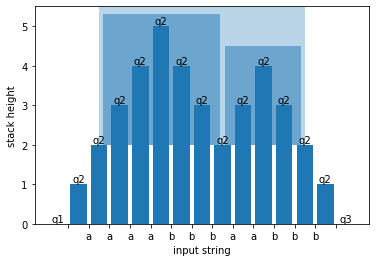

In [22]:
fig, ax = plt.subplots()
plot_height(ax, r.shortest_path())
ax.add_patch(patches.Rectangle((2,2),10,3.5,alpha=0.3))
ax.add_patch(patches.Rectangle((2.2,2),5.7,3.3,alpha=0.5))
ax.add_patch(patches.Rectangle((8.1,2),3.7,2.5,alpha=0.5))
plt.show()

So we should add a rule $A_{q_2q_2} \rightarrow A_{q_2q_2} A_{q_2q_2}$.

The PDA to CFG construction does this, but not for a particular string; it does this for all possible strings. The book's version generates a lot more rules than are usually necessary. Let's run the construction but remove the useless rules:

In [23]:
to_grammar(mc).remove_useless()

Even after removing useless rules, there are still some that don't really need to be there; but hopefully it's clear that the grammar generates the right language. "start" and "accept" are the names of states that were added to the PDA during preprocessing.